# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [36]:
#pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations 

^C
Note: you may need to restart the kernel to use updated packages.


In [12]:
#pip install opencv-python --user

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.3.0
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backpor

### 1.2 Collect Images Using OpenCV

In [1]:
import os 
import time
import uuid
import cv2

In [36]:
IMAGES_PATH = os.path.join('data','amarillo')
number_images = 45

In [37]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}ama.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [65]:
!labelme

"labelme" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [39]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2805327388466561664
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2240439911
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16892636000114587043
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [21]:
images = tf.data.Dataset.list_files('basededatos\\images\\images_amarrillo\\*.jpg')

In [22]:
images.as_numpy_iterator().next()

b'basededatos\\images\\images_amarrillo\\5c5dc2d6-7961-11ed-97dc-346f2492e578.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [24]:
images = images.map(load_image)

In [25]:
images.as_numpy_iterator().next()

array([[[154, 154, 154],
        [153, 153, 153],
        [141, 141, 141],
        ...,
        [143, 149, 147],
        [143, 147, 146],
        [142, 146, 145]],

       [[151, 151, 151],
        [152, 152, 152],
        [142, 142, 142],
        ...,
        [143, 149, 147],
        [143, 147, 146],
        [142, 146, 145]],

       [[154, 154, 154],
        [153, 153, 153],
        [147, 147, 147],
        ...,
        [142, 148, 146],
        [142, 148, 146],
        [141, 147, 145]],

       ...,

       [[ 78,  76,  77],
        [ 78,  76,  77],
        [ 77,  77,  75],
        ...,
        [ 36,  36,  36],
        [ 35,  37,  34],
        [ 34,  36,  33]],

       [[ 77,  76,  74],
        [ 78,  77,  75],
        [ 77,  77,  75],
        ...,
        [ 35,  37,  34],
        [ 34,  36,  33],
        [ 34,  36,  33]],

       [[ 77,  76,  74],
        [ 78,  77,  75],
        [ 77,  77,  75],
        ...,
        [ 34,  36,  33],
        [ 34,  36,  33],
        [ 34,  36,  33]]

In [26]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [27]:
image_generator = images.batch(4).as_numpy_iterator()

In [28]:
plot_images = image_generator.next()

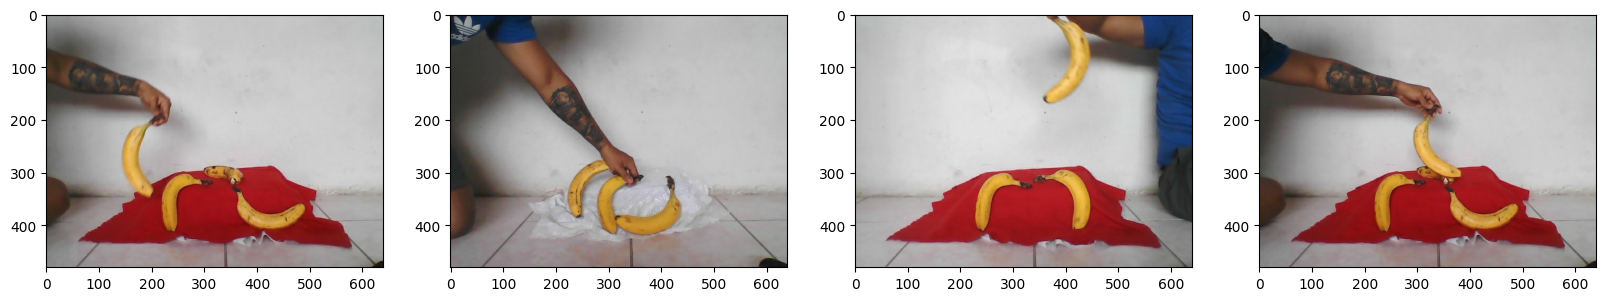

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [30]:
156*.7 # 63 to train

109.19999999999999

In [31]:
156*.15 # 14 and 13 to test and val

23.4

### 3.2 Move the Matching Labels

In [44]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [11]:
#pip install albumentations 

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
     --------------------------------------- 12.1/12.1 MB 15.2 MB/s eta 0:00:00
  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-win_amd64.whl (35.5 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
     ---------------------------------------- 7.1/7.1 MB 13.8 MB/s eta 0:00:00
     ---------------------------------------- 178.9/178.9 kB ? eta 0:00:00
  Using cached imageio-2.22.4-py3-none-any.whl (3.4 MB)
     ---------------------------------------- 4.2/4.2 MB 20.4 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 20.4 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import albumentations as alb

In [4]:
augmentor = alb.Compose([alb.RandomCrop(width=480, height=480), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomRotate90(),
                         alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5) ,
                         alb.VerticalFlip(p=0.5)])

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [93]:
img = cv2.imread(os.path.join('data','images_apto','0ec03fa2-7a3e-11ed-bf69-346f2492e578ama.jpg'))

### 4.4 Apply Augmentations and View Results

In [96]:
augmented = augmentor(image=img)

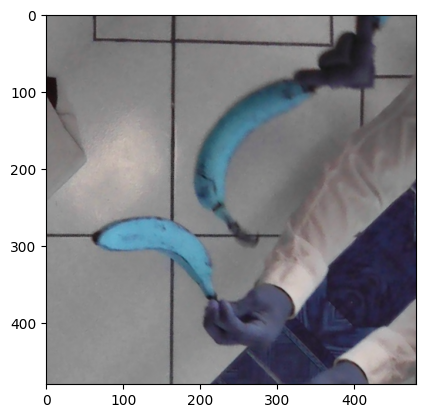

In [97]:
plt.imshow(augmented['image'])

In [98]:
for partition in ['images_apto']: 
    for image in os.listdir(os.path.join('data', 'images_apto')):
        img = cv2.imread(os.path.join('data', 'images_apto', image))
        
        for x in range(5):
            augmented = augmentor(image=img)
            cv2.imwrite(os.path.join('aug_data', 'images_apto', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])


In [5]:
for partition in ['images_noapto']: 
    for image in os.listdir(os.path.join('data', 'images_noapto')):
        img = cv2.imread(os.path.join('data', 'images_noapto', image))
        
        for x in range(5):
            augmented = augmentor(image=img)
            cv2.imwrite(os.path.join('aug_data', 'images_noapto', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])


# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [58]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['PNegro'])
                cv2.imwrite(os.path.join('platano_negro', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 3
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('platano_negro', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [147]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [148]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [149]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [150]:
train_images.as_numpy_iterator().next()

array([[[0.5411765 , 0.5411765 , 0.5411765 ],
        [0.54509807, 0.54509807, 0.54509807],
        [0.54148287, 0.54148287, 0.54148287],
        ...,
        [0.09932598, 0.10079657, 0.08854166],
        [0.02561275, 0.0377451 , 0.0377451 ],
        [0.        , 0.01727941, 0.03455883]],

       [[0.54295343, 0.54295343, 0.54295343],
        [0.5407475 , 0.5407475 , 0.5407475 ],
        [0.5416667 , 0.5416667 , 0.5416667 ],
        ...,
        [0.10153186, 0.10545343, 0.08535539],
        [0.06605392, 0.07389706, 0.06029412],
        [0.0026348 , 0.00833333, 0.00790441]],

       [[0.5449142 , 0.5449142 , 0.5449142 ],
        [0.5411765 , 0.5411765 , 0.5411765 ],
        [0.5446078 , 0.5446078 , 0.5446078 ],
        ...,
        [0.08976716, 0.10153186, 0.07408088],
        [0.08976716, 0.09368873, 0.07015932],
        [0.05036765, 0.05674019, 0.04203431]],

       ...,

       [[0.45294118, 0.41764706, 0.42941177],
        [0.45147058, 0.42794117, 0.4357843 ],
        [0.45091912, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [151]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [152]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [153]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [154]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [155]:
train_labels.as_numpy_iterator().next()

(array([3], dtype=uint8),
 array([0.2751, 0.436 , 0.3516, 0.6436], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [156]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 720, 720, 660, 660)

### 7.2 Create Final Datasets (Images/Labels)

In [157]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [158]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [159]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [160]:
train.as_numpy_iterator().next()[1]

(array([[3],
        [2],
        [3],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3862 , 0.07544, 0.595  , 0.3374 ],
        [0.4836 , 0.46   , 0.7876 , 0.8457 ],
        [0.4404 , 0.0687 , 0.6494 , 0.3308 ],
        [0.3408 , 0.6626 , 0.508  , 1.     ],
        [0.3774 , 0.6934 , 0.528  , 0.9434 ],
        [0.5254 , 0.2754 , 0.7544 , 0.364  ],
        [0.3918 , 0.5884 , 0.6626 , 0.674  ],
        [0.732  , 0.1174 , 0.8726 , 0.3728 ]], dtype=float16))

### 7.3 View Images and Annotations

In [161]:
data_samples = train.as_numpy_iterator()

In [162]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


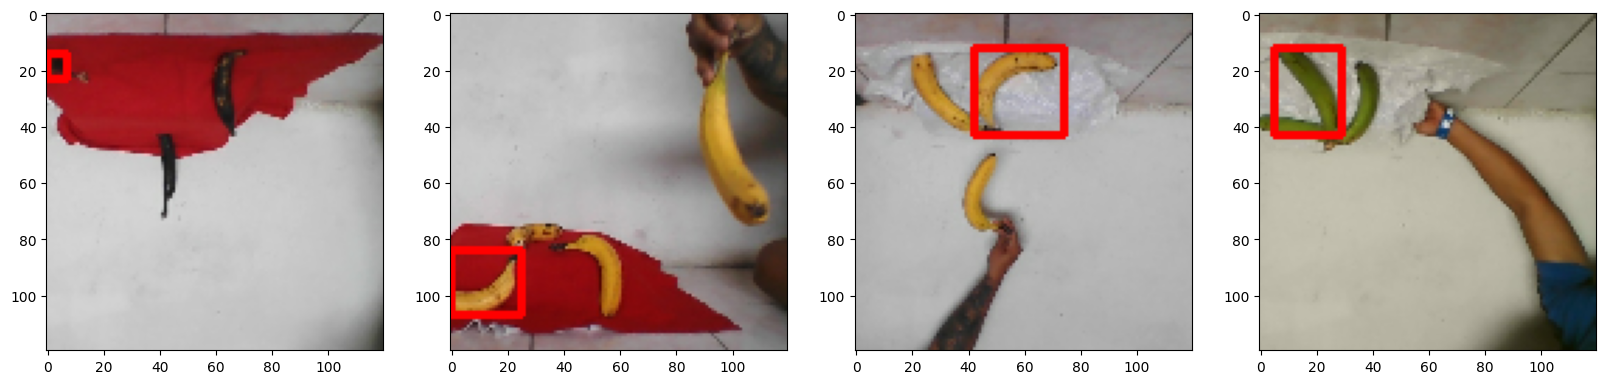

In [163]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [164]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [165]:
vgg = VGG16(include_top=False)

In [166]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [167]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(4, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [168]:
facetracker = build_model()

In [169]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

In [170]:
X, y = train.as_numpy_iterator().next()

In [171]:
X.shape

(8, 120, 120, 3)

In [172]:
classes, coords = facetracker.predict(X)

In [173]:
classes, coords

(array([[0.26999494, 0.24647348, 0.24657245, 0.23695908],
        [0.25920317, 0.19533081, 0.18747014, 0.35799593],
        [0.32366568, 0.28845316, 0.12915418, 0.25872692],
        [0.32034495, 0.20775256, 0.26099136, 0.21091114],
        [0.26319835, 0.22482127, 0.14190666, 0.37007368],
        [0.3951713 , 0.19030386, 0.1373046 , 0.27722028],
        [0.27165422, 0.20170583, 0.2691555 , 0.25748447],
        [0.27755943, 0.20564581, 0.1948825 , 0.3219123 ]], dtype=float32),
 array([[0.82425207, 0.5768835 , 0.58567584, 0.53926253],
        [0.8636411 , 0.6566032 , 0.7172395 , 0.67833006],
        [0.8054587 , 0.6311078 , 0.6382841 , 0.60417885],
        [0.83827734, 0.6100782 , 0.56482506, 0.52579373],
        [0.80690706, 0.5878734 , 0.5149194 , 0.64130944],
        [0.816456  , 0.6287871 , 0.644163  , 0.5721734 ],
        [0.7972022 , 0.56108123, 0.5505376 , 0.50409526],
        [0.75358343, 0.6537531 , 0.66169405, 0.53175485]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [174]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [175]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [176]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [221]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [222]:
classloss

### 9.3 Test out Loss Metrics

In [223]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.9164333>

In [224]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5330753>

In [225]:
classes

array([[0.26999494, 0.24647348, 0.24657245, 0.23695908],
       [0.25920317, 0.19533081, 0.18747014, 0.35799593],
       [0.32366568, 0.28845316, 0.12915418, 0.25872692],
       [0.32034495, 0.20775256, 0.26099136, 0.21091114],
       [0.26319835, 0.22482127, 0.14190666, 0.37007368],
       [0.3951713 , 0.19030386, 0.1373046 , 0.27722028],
       [0.27165422, 0.20170583, 0.2691555 , 0.25748447],
       [0.27755943, 0.20564581, 0.1948825 , 0.3219123 ]], dtype=float32)

In [226]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.9164333>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [227]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [228]:
model = FaceTracker(facetracker)

In [229]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [230]:
logdir='logs'

In [231]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [232]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
315/315 [==============================] - 40s 115ms/step - total_loss: 1.2535 - class_loss: 2.4603 - regress_loss: 0.0233 - val_total_loss: 1.3020 - val_class_loss: 1.9358 - val_regress_loss: 0.3341
Epoch 2/30
315/315 [==============================] - 36s 109ms/step - total_loss: 1.2378 - class_loss: 2.4615 - regress_loss: 0.0071 - val_total_loss: 1.3529 - val_class_loss: 2.4851 - val_regress_loss: 0.1103
Epoch 3/30
315/315 [==============================] - 36s 110ms/step - total_loss: 1.2335 - class_loss: 2.4615 - regress_loss: 0.0027 - val_total_loss: 1.6404 - val_class_loss: 2.4851 - val_regress_loss: 0.3979
Epoch 4/30
315/315 [==============================] - 36s 109ms/step - total_loss: 1.2323 - class_loss: 2.4615 - regress_loss: 0.0016 - val_total_loss: 1.7344 - val_class_loss: 3.3090 - val_regress_loss: 0.0799
Epoch 5/30
315/315 [==============================] - 36s 110ms/step - total_loss: 1.2319 - class_loss: 2.4610 - regress_loss: 0.0014 - val_total_loss: 1.66

### 10.3 Plot Performance

In [233]:
hist.history

{'total_loss': [1.1136547327041626,
  1.312864899635315,
  1.3139148950576782,
  1.3119813203811646,
  1.2442547082901,
  1.6552356481552124,
  1.2429287433624268,
  1.1100565195083618,
  1.4487886428833008,
  1.1749753952026367,
  1.037235975265503,
  0.977188766002655,
  1.3802459239959717,
  1.242985486984253,
  1.243058204650879,
  1.4490835666656494,
  0.9681640863418579,
  1.3800908327102661,
  1.1750506162643433,
  1.312131404876709,
  1.2431565523147583,
  1.037158727645874,
  1.3114210367202759,
  1.105546236038208,
  1.3117979764938354,
  0.9688562154769897,
  1.1748247146606445,
  1.3803167343139648,
  1.380260705947876,
  1.1053485870361328],
 'class_loss': [2.2102952003479004,
  2.6222805976867676,
  2.622265338897705,
  2.6222779750823975,
  2.484964370727539,
  3.3089075088500977,
  2.4849345684051514,
  2.2102770805358887,
  2.8969149589538574,
  2.347593307495117,
  2.072941780090332,
  1.9356189966201782,
  2.7595720291137695,
  2.4849493503570557,
  2.484942436218261

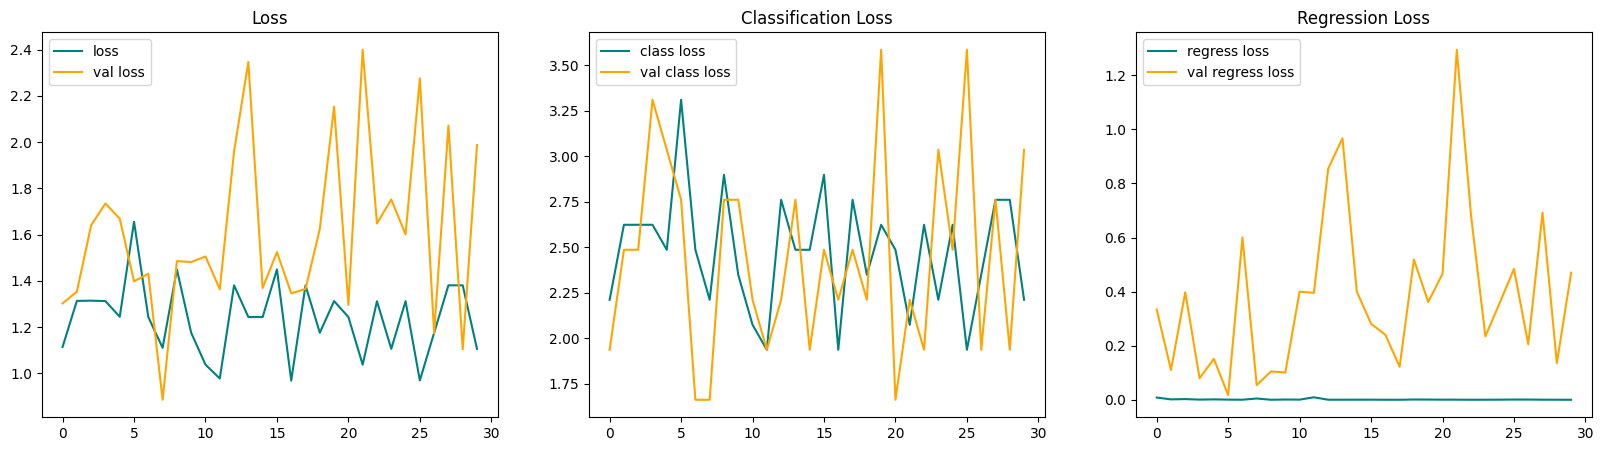

In [234]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [235]:
test_data = test.as_numpy_iterator()

In [258]:
test_sample = test_data.next()

In [259]:
yhat = facetracker.predict(test_sample[0])

In [260]:
#yhat[0].mean()

In [261]:
facetracker.predict(test_sample[0])

[array([[0.25183883, 0.25208485, 0.24919043, 0.24688591],
        [0.2532116 , 0.2472017 , 0.24449968, 0.25508705],
        [0.24731417, 0.24597329, 0.25162247, 0.25509003],
        [0.24760358, 0.246589  , 0.24962072, 0.25618666],
        [0.25051767, 0.24990387, 0.2508715 , 0.24870692],
        [0.24860542, 0.25111455, 0.24956037, 0.25071973],
        [0.25114468, 0.25161904, 0.2506723 , 0.24656397],
        [0.24409853, 0.24895237, 0.25491628, 0.25203276]], dtype=float32),
 array([[0.3653123 , 0.65943974, 0.57137376, 0.9637635 ],
        [0.38675544, 0.6145681 , 0.57983714, 0.8379501 ],
        [0.18903716, 0.6139237 , 0.3510267 , 0.9423292 ],
        [0.34066457, 0.62267196, 0.49912024, 0.942284  ],
        [0.45799536, 0.12702289, 0.59590113, 0.3740271 ],
        [0.43209666, 0.63798064, 0.57561   , 0.8820954 ],
        [0.37951764, 0.12943263, 0.5988564 , 0.34138238],
        [0.36097845, 0.1672778 , 0.5557943 , 0.41643506]], dtype=float32)]

In [262]:
yhat[0][2]

array([0.24731417, 0.24597329, 0.25162247, 0.25509003], dtype=float32)

In [263]:
 test_sample[0][1][0]

array([[0.61807597, 0.61807597, 0.61807597],
       [0.6240196 , 0.6240196 , 0.6240196 ],
       [0.627451  , 0.627451  , 0.627451  ],
       [0.62352943, 0.62352943, 0.62352943],
       [0.6273897 , 0.6273897 , 0.6273897 ],
       [0.6315564 , 0.6315564 , 0.6315564 ],
       [0.6313726 , 0.6313726 , 0.6313726 ],
       [0.62892157, 0.62892157, 0.62892157],
       [0.63192403, 0.63192403, 0.63192403],
       [0.6367647 , 0.6367647 , 0.6367647 ],
       [0.6384191 , 0.6384191 , 0.6384191 ],
       [0.64460784, 0.64460784, 0.64460784],
       [0.6461397 , 0.6461397 , 0.6461397 ],
       [0.6431373 , 0.6431373 , 0.6431373 ],
       [0.64705884, 0.64705884, 0.64705884],
       [0.6518995 , 0.6518995 , 0.6518995 ],
       [0.65006125, 0.65006125, 0.65006125],
       [0.64460784, 0.64460784, 0.64460784],
       [0.6504902 , 0.6504902 , 0.6504902 ],
       [0.654902  , 0.654902  , 0.654902  ],
       [0.654902  , 0.654902  , 0.654902  ],
       [0.65275735, 0.65275735, 0.65275735],
       [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


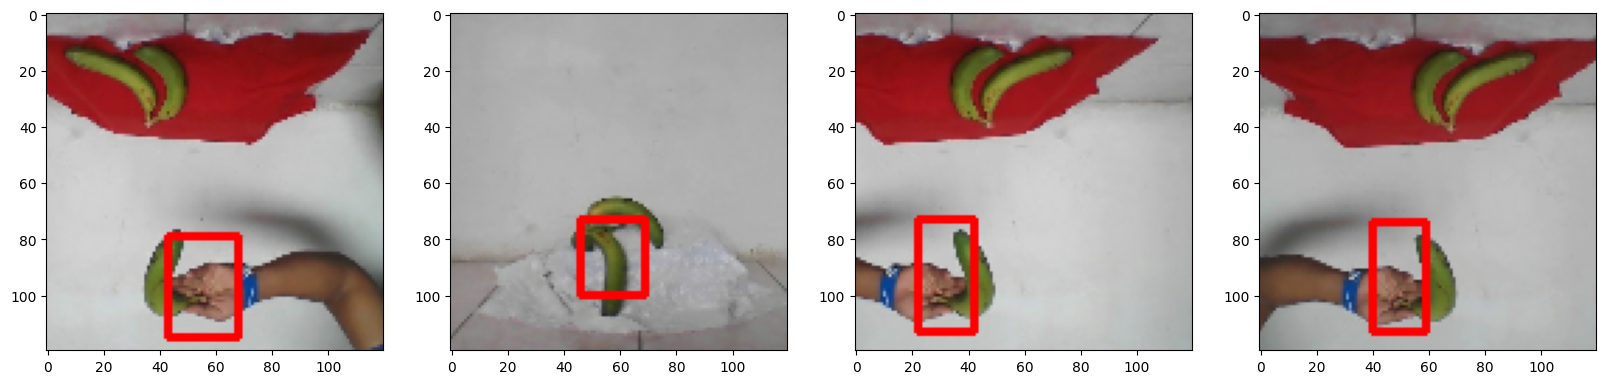

In [264]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][2][idx] > 0.1:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
        
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [265]:
from tensorflow.keras.models import load_model

In [266]:
facetracker.save('prueba.h5')

In [267]:
facetracker = load_model('prueba.h5')

In [268]:
yhat[0][0][2]

0.24919043

In [269]:
yhat

[array([[0.25183883, 0.25208485, 0.24919043, 0.24688591],
        [0.2532116 , 0.2472017 , 0.24449968, 0.25508705],
        [0.24731417, 0.24597329, 0.25162247, 0.25509003],
        [0.24760358, 0.246589  , 0.24962072, 0.25618666],
        [0.25051767, 0.24990387, 0.2508715 , 0.24870692],
        [0.24860542, 0.25111455, 0.24956037, 0.25071973],
        [0.25114468, 0.25161904, 0.2506723 , 0.24656397],
        [0.24409853, 0.24895237, 0.25491628, 0.25203276]], dtype=float32),
 array([[0.3653123 , 0.65943974, 0.57137376, 0.9637635 ],
        [0.38675544, 0.6145681 , 0.57983714, 0.8379501 ],
        [0.18903716, 0.6139237 , 0.3510267 , 0.9423292 ],
        [0.34066457, 0.62267196, 0.49912024, 0.942284  ],
        [0.45799536, 0.12702289, 0.59590113, 0.3740271 ],
        [0.43209666, 0.63798064, 0.57561   , 0.8820954 ],
        [0.37951764, 0.12943263, 0.5988564 , 0.34138238],
        [0.36097845, 0.1672778 , 0.5557943 , 0.41643506]], dtype=float32)]

In [270]:
facetracker.__class__

keras.engine.functional.Functional

### 11.3 Real Time Detection

In [102]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0][0][0] > 0.3: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [10]:
pip list

Package                 Version
----------------------- --------------
absl-py                 1.3.0
aiohttp                 3.8.3
aiosignal               1.2.0
albumentations          1.3.0
anyio                   3.5.0
argon2-cffi             21.3.0
argon2-cffi-bindings    21.2.0
astor                   0.8.1
asttokens               2.0.5
astunparse              1.6.3
async-timeout           4.0.2
attrs                   22.1.0
backcall                0.2.0
beautifulsoup4          4.11.1
bleach                  4.1.0
blinker                 1.4
brotlipy                0.7.0
cachetools              4.2.2
certifi                 2022.9.24
cffi                    1.15.1
charset-normalizer      2.0.4
click                   8.0.4
colorama                0.4.5
contourpy               1.0.6
cryptography            38.0.1
cycler                  0.11.0
debugpy                 1.5.1
decorator               5.1.1
defusedxml              0.7.1
entrypoints             0.4
executing             